# Application of Deep Learning on Cancer Images
### 1000-719bMSB MIM UW, Neo Christopher Chung

In this lab, we make a prediction of lung nodules by a deep learning model and explain that decision making process by attention maps and CDAMs. For the simplicity, we provide a pre-trained model and use an existing medical image dataset. To streamline XAI, we are using a Python library called Obz.

## Download the obz package

From your venv, clone:
```git clone http://github.com/obzai/obz```

If you have never used a virtual environment for Python, consider using uv.

Alternatively, you can download the repo from the website.

Take a note where you clone the obz repo, and set the working directory to that path. The following codes assume that you are in this repo root directory.

In [ ]:
# pip install torch torchvision torchmetrics .. etc
import sys
import os
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch
from torch import nn
import numpy as np
import gdown
import os
import matplotlib.pyplot as plt

# Repository root directory
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)
print(repo_root)

/Users/ncc/GitHub/obz


## Download the pre-trained ViT model

**Obz package** is designed to monitor your vision models behaviour. In particular it logs *post hoc* explainability maps and might detect outliers. However, first of all you need to define your model which you would like to monitor.  
So, let's define a simple Vision Transformer based on DINO ViT Backbone! Especially for you I have finetuned DINO VIT model on *LIDC-IDRI* dataset. We will utilize it for a tutorial!

In [ ]:
def download_weights(url, output_dir, filename):
    """
    Downloads weights from the given URL if they are not already downloaded.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)

    if not os.path.exists(output_path):
        print(f"Downloading weights to {output_path}...")
        gdown.download(url, output_path)
    else:
        print(f"Weights already exist at {output_path}. Skipping download.")

url = "https://drive.google.com/uc?id=1xUevCbvII5yXDxVxb7bR65CPmgz2sGQA"
output_dir = "tuned_models"
filename = "lidc_dino_s8.pth"
download_weights(url, output_dir, filename)

Weights already exist at tuned_models/lidc_dino_s8.pth. Skipping download.


## Configure the ViT classifer based on DINO backbone

We are adding a binary classification head (see how ```torch.nn.Linear```) onto a DINO backbone.

In [ ]:
from transformers import ViTConfig, ViTModel

class DINO(nn.Module):
    """
    DINO Transformer model based on Huggingface implementation.
    """
    def __init__(self):
        super().__init__()
        # Backbone
        config = ViTConfig.from_pretrained('facebook/dino-vits8', attn_implementation="eager") # We propose eager implementation to return att scores gracefully.
        self.backbone = ViTModel(config)
        # Classfication head
        self.head = torch.nn.Linear(384, 1)

    def forward(self, x: torch.Tensor, output_attentions:bool=False):
        out = self.backbone(x, output_attentions=output_attentions)
        x = out["pooler_output"]
        x = self.head(x)
        if output_attentions:
            att = out["attentions"]
            return x, att
        else:
            return x

We load the pre-trained weights onto this model.

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHTS_PATH = "./tuned_models/lidc_dino_s8.pth"

MODEL = DINO()
MODEL.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=True, map_location=torch.device(DEVICE)))
MODEL = MODEL.to(DEVICE).eval()

Next, let's prepare datasets. You need two source of images! One is **Reference** dataset, which will be used to extract reference image features and fit outlier detection utilities. Second one, **Inference** dataset will act as incoming new data which uou would like to monitor.  
For the tutorial case we will use LIDC-IDRI subset called: **Nodule MNIST**. This dataset is readily available via **MedMNIST** package. If you don't have MedMNIST, please install it with a command below.

In [ ]:
## Install medmnist package if you don't have already
# pip install medmnist

from medmnist import NoduleMNIST3D

In [ ]:
# Transforms
def take_middle_slice(inpt: np.ndarray):
    """
    NoduleMNIST 3D contains whole nodule volumes, however for this tutorial
    we will utilize only central slice of each example.
    We repeat this slice 3 times, as model expects input to have 3 channels.
    """
    inpt = inpt.squeeze()
    X, Y, Z = inpt.shape
    slice_ = inpt[:, :, Z//2]
    slice_ = torch.Tensor(slice_).unsqueeze(dim=0).repeat(3,1,1)
    return slice_

TRANSFORMS = v2.Compose([v2.Lambda(take_middle_slice),
                         v2.Resize(size=(224,224))
                         ])

NORMALIZE = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Datasets
data_dir = "./example_data"
os.makedirs(data_dir, exist_ok=True)

## Reference data. We will use it as source of reference statistics and to "train" OutlierDetector.
ref_set = NoduleMNIST3D(root=data_dir, split="val", size=64, transform=TRANSFORMS, download=True)
## Inference data. We will use it as exemplary source of production data.
inf_set = NoduleMNIST3D(root=data_dir, split="test", size=64, transform=TRANSFORMS)

# DataLoaders
ref_loader = DataLoader(ref_set, batch_size=32, shuffle=False)
inf_loader = DataLoader(inf_set, batch_size=6, shuffle=True)

## NOTE that for homework, download a training set and train ViT models
# train_set = NoduleMNIST3D(root=data_dir, split="train", size=64, transform=TRANSFORMS, download=True)
# train_loader = DataLoader(train_set, batch_size=32, shuffle=False)

# Labels mapping
CLASS_NAMES = ["benign", "malignant"]

LOGIT2NAME = {
    0: "benign",
    1: "malignant",
}


Visualize the first 5 samples from ref_loader

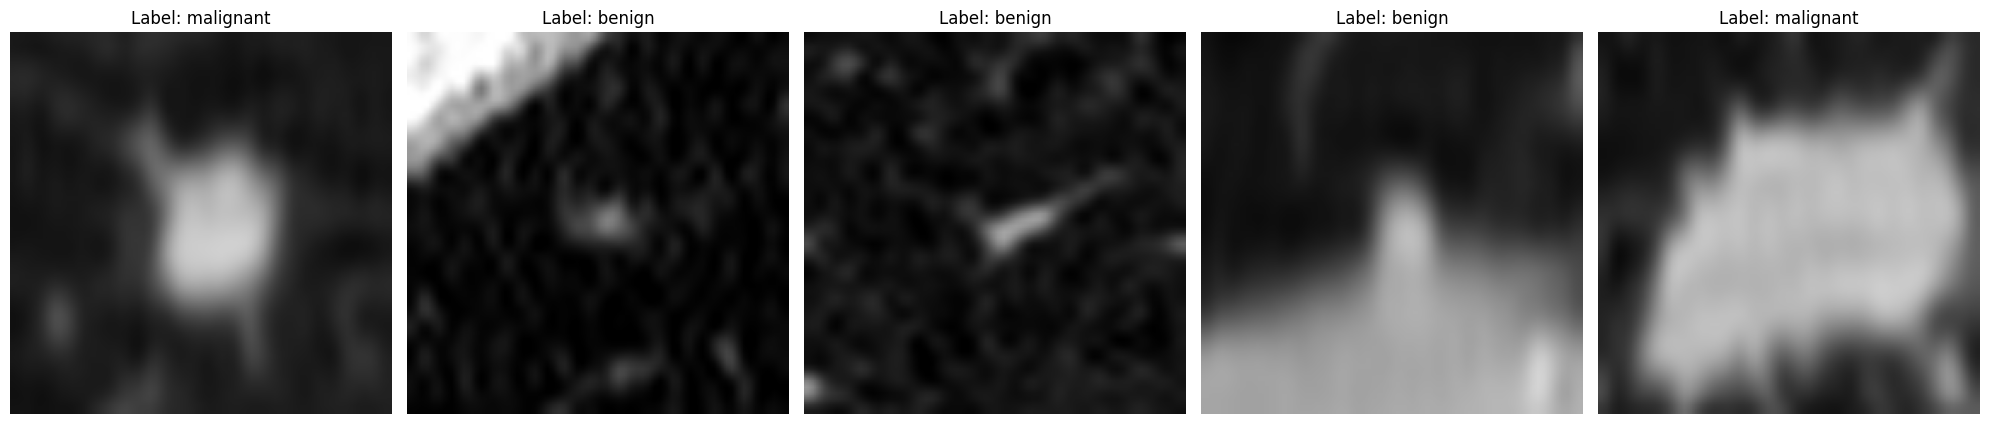

In [ ]:
samples, labels = next(iter(ref_loader))

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    image = samples[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {CLASS_NAMES[labels[i].item()]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Make the prediction for those 5 samples using the aforementioned MODEL

In [ ]:
# Move samples to the appropriate device
samples = samples[:5].to(DEVICE)
labels = labels[:5].to(DEVICE)
print(labels)
print(samples.shape)

# Dont normalize the LIDC data?
# Normalize the samples
#samples = NORMALIZE(samples)

# Perform inference using the model
with torch.no_grad():
    logits = MODEL(samples)
    predictions = torch.sigmoid(logits).round().squeeze().cpu().numpy()

# Map predictions to class names
predicted_classes = [LOGIT2NAME[int(pred)] for pred in predictions]

# Print the results
for i, pred_class in enumerate(predicted_classes):
    print(f"Prediction for Sample {i + 1}: {pred_class}")

tensor([[1],
        [0],
        [0],
        [0],
        [1]])
torch.Size([5, 3, 224, 224])
Prediction for Sample 1: malignant
Prediction for Sample 2: benign
Prediction for Sample 3: benign
Prediction for Sample 4: benign
Prediction for Sample 5: malignant


## Extract features for outlier detection

You can use Data Inspector Module and XAI Module locally to detect outliers and compute explainability maps.
You need to instantiate `OutlierDetector` from Data Inspector Module and desired `XAI Tools` from XAI Module.

In [ ]:
# Setup OutlierDetector
from data_inspector.extractor import FirstOrderExtractor
from data_inspector.detector import GMMDetector
# Choose desired feature extractor. Chosen extractor will be used for monitoring.
first_order_extrc = FirstOrderExtractor()

# Pass choosen extractor(s) to chosen OutlierDetector. Below we utilize outlier detector based on Gaussian Mixture Models.
gmm_detector = GMMDetector(extractors=[first_order_extrc], n_gaussian_components=3, outlier_quantile=0.01)
# Call .fit() method with passed reference dataloader.
# Method will extract desired image features and fit outlier detection model (in that case GMM).
gmm_detector.fit(ref_loader)


Preparing features for a reference dataset ...


Extracting with FirstOrderExtractor: 100%|██████████| 6/6 [00:09<00:00,  1.53s/batch]


## Explain the AI model

#### We first need to choose and set up appropriate XAI tools.

In [ ]:
# Setup XAI Tools
from xai.xai_tool import CDAM, AttentionMap

# Choose desired XAI Tools
cdam_tool = CDAM(model=MODEL,
                 mode='vanilla',                      # CDAM mode
                 gradient_type="from_logits",  # Whether backpropagate gradients from logits or probabilities.
                 gradient_reduction="average",        # Gradient reduction method.
                 activation_type="sigmoid")           # Activation function applied on logits. (Needed when gradients are backpropagated from probabilities.)
# In CDAM you need to specify on which layer you want to create hooks.
cdam_tool.create_hooks(layer_name="backbone.encoder.layer.11.layernorm_before")

attention_tool = AttentionMap(model=MODEL,
                              attention_layer_id = -1,# ID of an attention layer from which to extract attention weights
                              head = None             # ID of attention head to choose. If None, attention scores are averaged.
                              )

#### Then, we can run the XAI method to our data.
We first apply and visualize attention maps

In [ ]:
# Apply attention_tool on the first ten samples
attention_maps = attention_tool.explain(samples)  # Use the appropriate method to generate attention maps

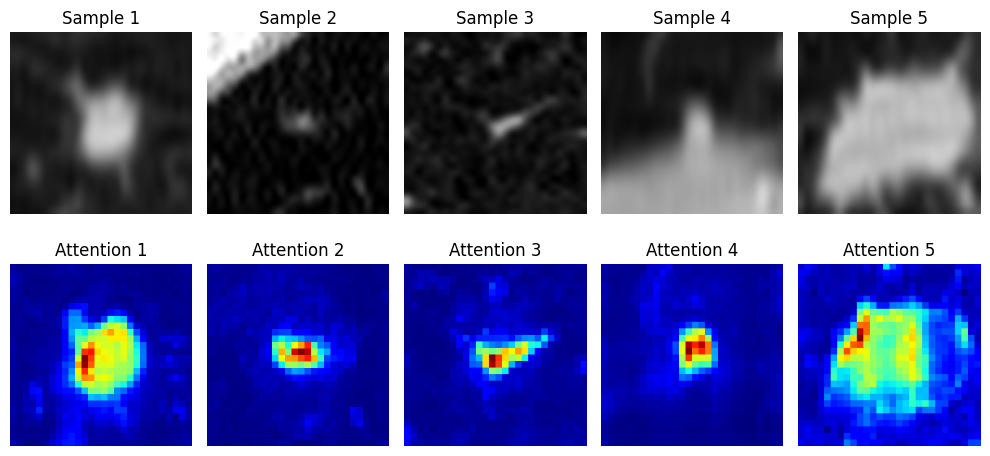

In [ ]:
# Visualize samples and attention maps
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# First row: Original samples
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Attention maps
for i in range(5):
    attention_map = attention_maps[i].cpu().numpy()
    axes[1, i].imshow(attention_map, cmap='jet')
    axes[1, i].set_title(f"Attention {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

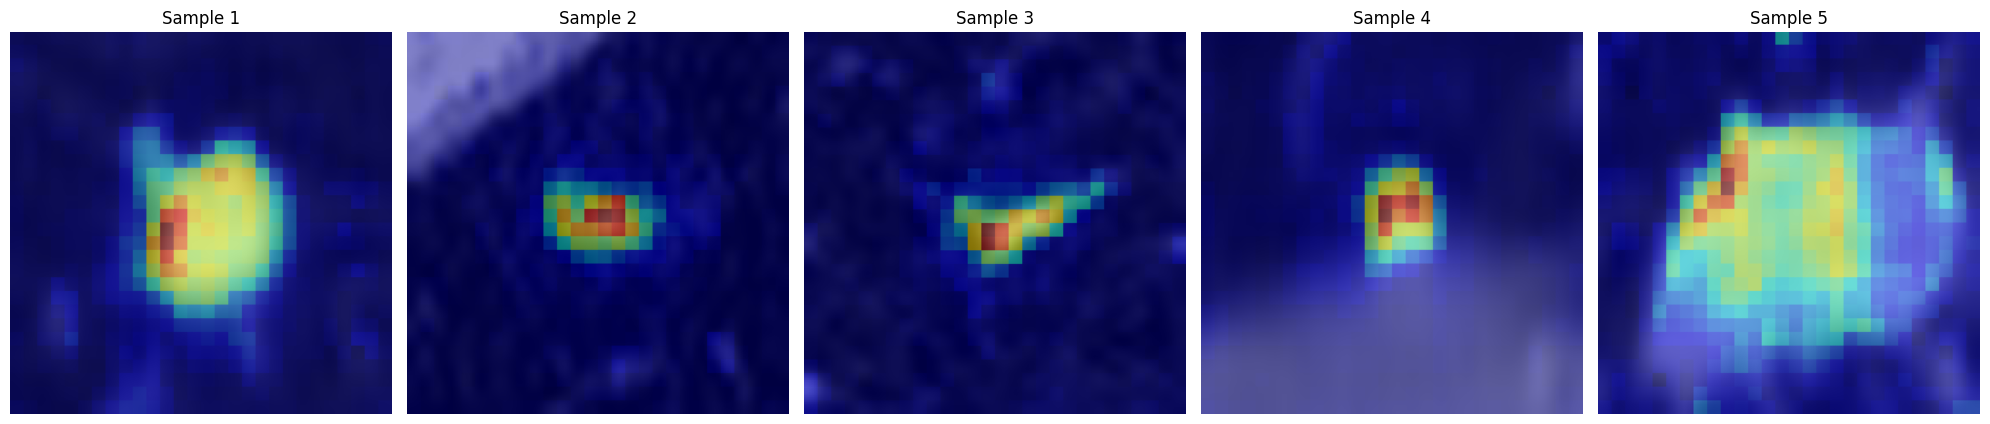

In [ ]:
# Visualize attention maps overlaid on samples
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    attention_map = attention_maps[i].cpu().numpy()  # Convert attention map to numpy array

    # Overlay attention map on the original image
    axes[i].imshow(original_image, cmap='gray')
    axes[i].imshow(attention_map, cmap='jet', alpha=0.5)  # Use alpha for transparency
    axes[i].set_title(f"Sample {i + 1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Generate and visualize CDAM maps

In [ ]:
# Generate CDAM maps
cdam_maps = cdam_tool.explain(samples, target_idx=[0,0,0,0,0])  # Use the appropriate method to generate CDAM maps

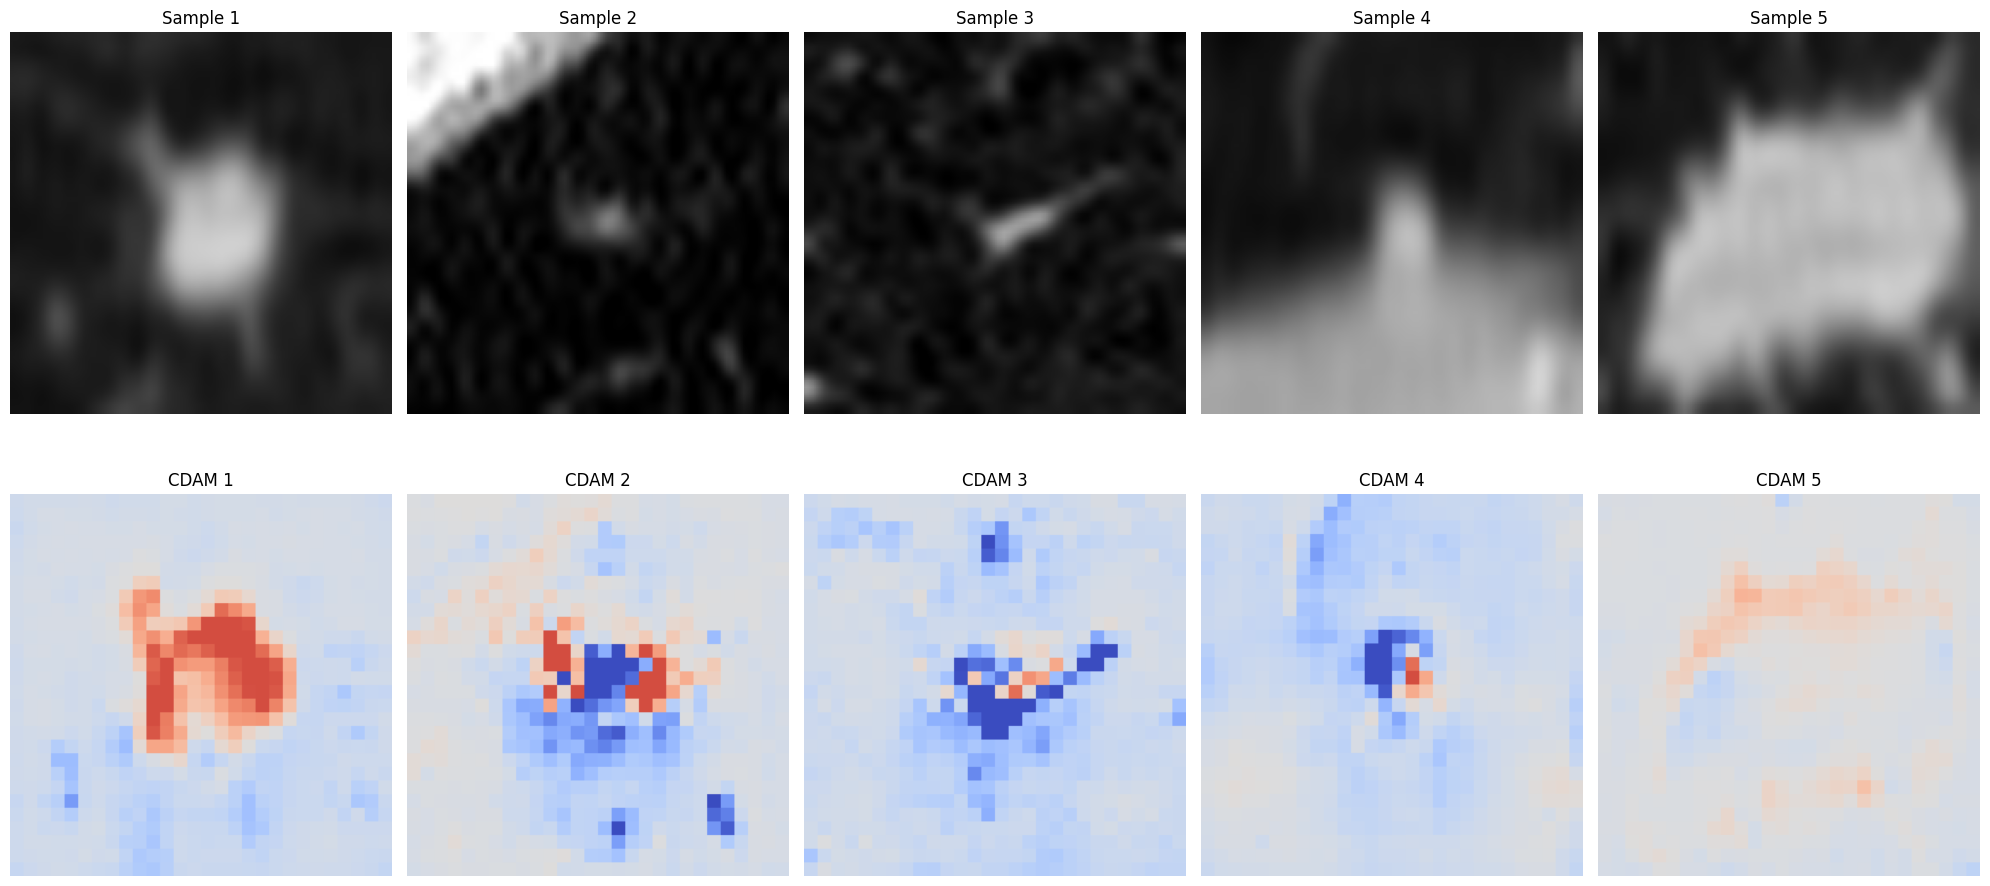

In [ ]:
# Visualize samples and CDAM maps
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# First row: Original samples
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: CDAM maps
for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].imshow(cdam_map, cmap='coolwarm', vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Diverging colormap
    axes[1, i].set_title(f"CDAM {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

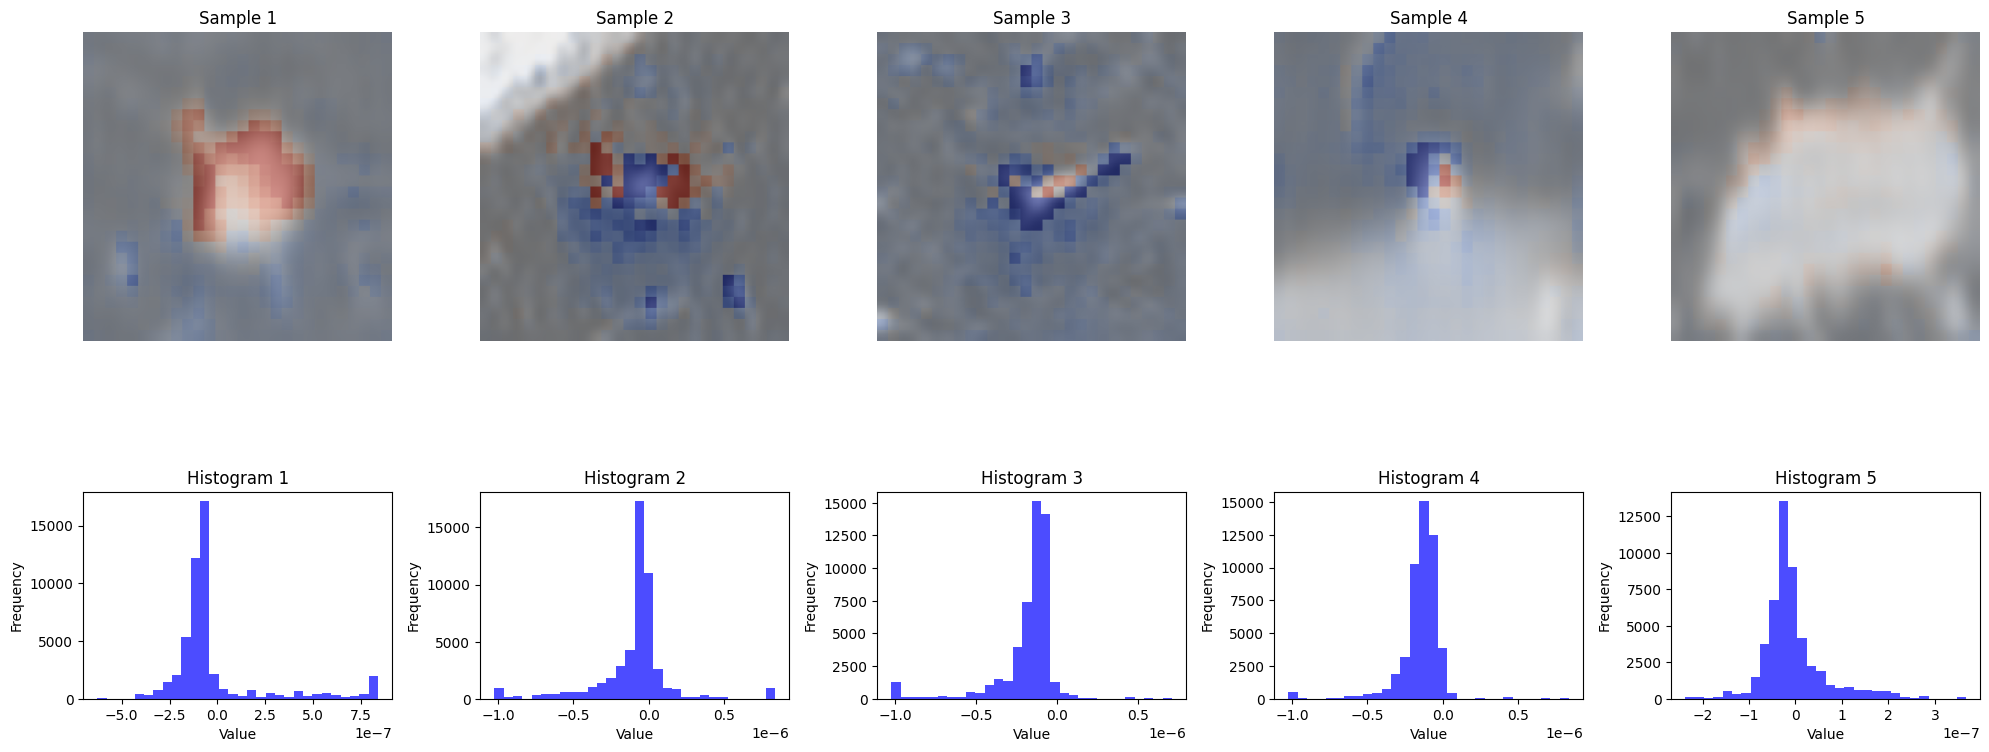

In [ ]:
# Visualize CDAM maps overlaid on samples with histogram and color bar
fig, axes = plt.subplots(2, 5, figsize=(20, 10), gridspec_kw={'height_ratios': [4, 1]})

# First row: Original samples with overlaid CDAM maps
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array

    # Overlay CDAM map on the original image
    im = axes[0, i].imshow(original_image, cmap='gray')
    im = axes[0, i].imshow(cdam_map, cmap='coolwarm', alpha=0.5, vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Use alpha for transparency
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Histogram of CDAM map values
for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].hist(cdam_map.ravel(), bins=30, color='blue', alpha=0.7)
    axes[1, i].set_title(f"Histogram {i + 1}")
    axes[1, i].set_xlabel('Value')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Homework (for 2 weeks)

Train a Vision Transformer model on any of MedMNIST datasets (except NoduleMNIST), followed by prediction and explanation.

Essentially apply the above steps with a different ViT model trained on one of the MedMNIST datasets.



In [3]:
!pip install torch torchvision timm medmnist matplotlib opencv-python scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [4]:
!pip install medmnist

In [5]:
!git clone https://github.com/obzai/obzai.git

Cloning into 'obzai'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 38 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 2.19 MiB | 12.59 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [6]:
import sys
sys.path.append("/content/obzai/src")
from obzai.data_inspector.extractor import FirstOrderExtractor
from obzai.data_inspector.detector import GMMDetector

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PathMNIST, INFO
from transformers import ViTModel, ViTConfig
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 1


In [55]:
from torch.utils.data import Subset
from torchvision import transforms
from medmnist import PathMNIST, INFO

info = INFO['pathmnist']
n_classes = len(info['label'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = PathMNIST(split='train', transform=transform, download=True)
val_dataset = PathMNIST(split='val', transform=transform, download=True)
test_dataset = PathMNIST(split='test', transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [56]:
class DINO(nn.Module):
    def __init__(self):
        super().__init__()
        config = ViTConfig.from_pretrained('facebook/dino-vits8', attn_implementation="eager")
        self.backbone = ViTModel(config)
        self.head = torch.nn.Linear(384, 9)

    def forward(self, x: torch.Tensor, output_attentions: bool = False):
        out = self.backbone(x, output_attentions=output_attentions)
        x = out["pooler_output"]
        x = self.head(x)
        if output_attentions:
            att = out["attentions"]
            return x, att
        else:
            return x

In [57]:
model = DINO().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [58]:
def train(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(loader, desc="Training"):
        imgs = imgs.to(DEVICE)
        labels = labels.view(-1).long().to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), correct / total

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(DEVICE)
            labels = labels.view(-1).long().to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total


In [59]:
import torch
torch.cuda.empty_cache()
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

torch.save(model.state_dict(), "dino_pathmnist.pth")
print("Model saved as dino_pathmnist.pth")

samples, labels = next(iter(test_loader))
samples = samples[:5].to(DEVICE)
labels = labels[:5].to(DEVICE)

Evaluating: 100%|██████████| 626/626 [03:24<00:00,  3.05it/s]


[Epoch 1] Train Loss: 0.6130, Train Acc: 0.7771 | Val Acc: 0.8400


Evaluating: 100%|██████████| 1795/1795 [02:23<00:00, 12.53it/s]


Test Accuracy: 0.7397
Model saved as dino_pathmnist.pth


In [61]:
import matplotlib.pyplot as plt


In [60]:
CLASS_NAMES = {
    0: "background",
    1: "tissue",
    2: "epithelial",
    3: "lymphocyte",
    4: "plasma",
    5: "eosinophil",
    6: "connective",
    7: "muscle",
    8: "nerve"
}


<ipython-input-65-4aea588b1f37>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_names = [CLASS_NAMES[int(l)] for l in labels.cpu().numpy()]


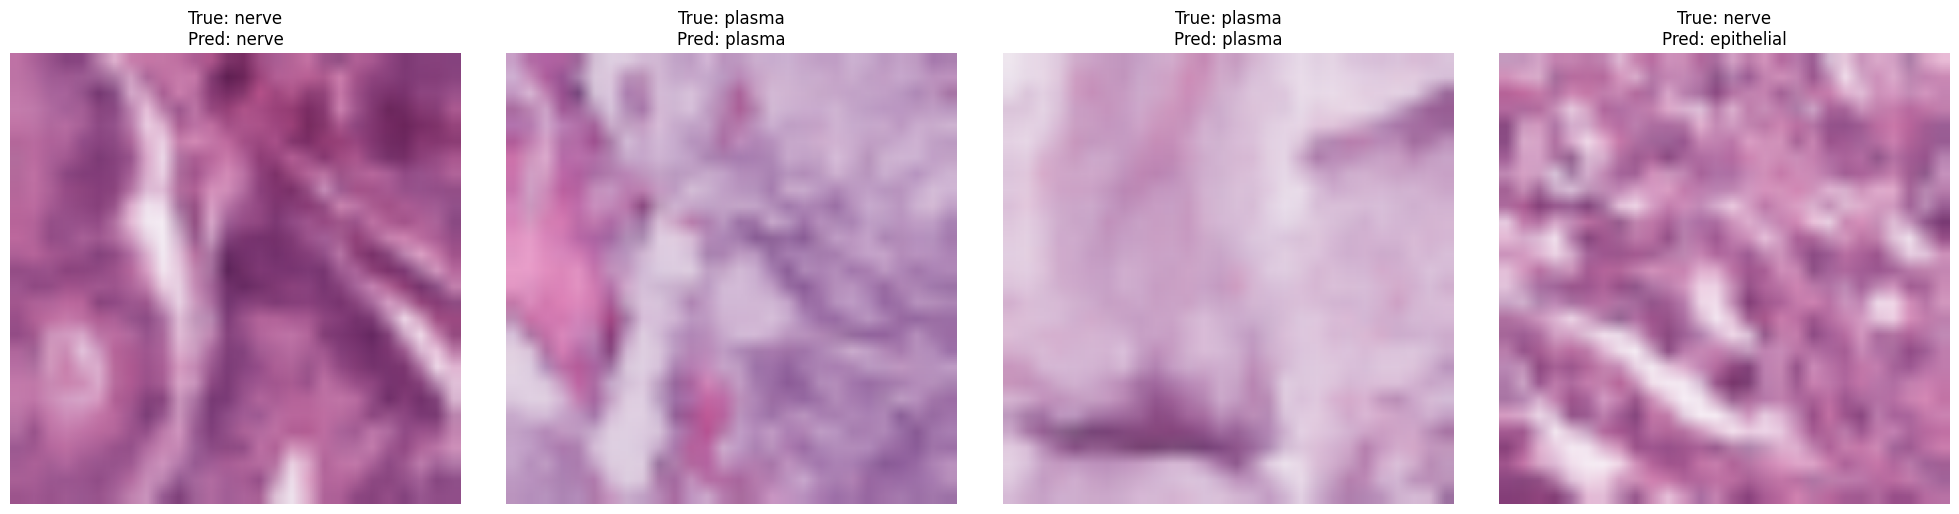

In [65]:
samples, labels = next(iter(test_loader))
samples = samples[:5].to(DEVICE)
labels = labels[:5].to(DEVICE)


model.eval()
with torch.no_grad():
    logits = model(samples)
    predictions = torch.softmax(logits, dim=1)
    predicted_classes = predictions.argmax(dim=1).cpu().numpy()


predicted_names = [CLASS_NAMES[int(p)] for p in predicted_classes]
true_names = [CLASS_NAMES[int(l)] for l in labels.cpu().numpy()]

fig, axes = plt.subplots(1, samples.size(0), figsize=(20, 5))

for i in range(samples.size(0)):
    image = samples[i].permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5) + 0.5
    axes[i].imshow(image)
    axes[i].set_title(f"True: {true_names[i]}\nPred: {predicted_names[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()



In [66]:
model.eval()
with torch.no_grad():
    logits = model(samples)
    probs = torch.softmax(logits, dim=1)


print("Predicted classes:", predicted_names)


Predicted classes: ['nerve', 'plasma', 'plasma', 'epithelial']


In [67]:
samples = samples[:5].to(DEVICE)
labels = labels[:5].to(DEVICE)

with torch.no_grad():
    logits = model(samples)
    predictions = torch.softmax(logits, dim=1).argmax(dim=1).cpu().numpy()

predicted_classes = [CLASS_NAMES[int(pred)] for pred in predictions]

for i, pred_class in enumerate(predicted_classes):
    print(f"Prediction for Sample {i + 1}: {pred_class}")


Prediction for Sample 1: nerve
Prediction for Sample 2: plasma
Prediction for Sample 3: plasma
Prediction for Sample 4: epithelial


In [68]:
!pip install captum


In [69]:
from obzai.xai.xai_tool import CDAM, AttentionMap

cdam_tool = CDAM(model=model,
                 mode='vanilla',
                 gradient_type="from_logits",
                 gradient_reduction="average",
                 activation_type="sigmoid")
cdam_tool.create_hooks(layer_name="backbone.encoder.layer.11.layernorm_before")

attention_tool = AttentionMap(model=model,
                              attention_layer_id=-1,
                              head=None)

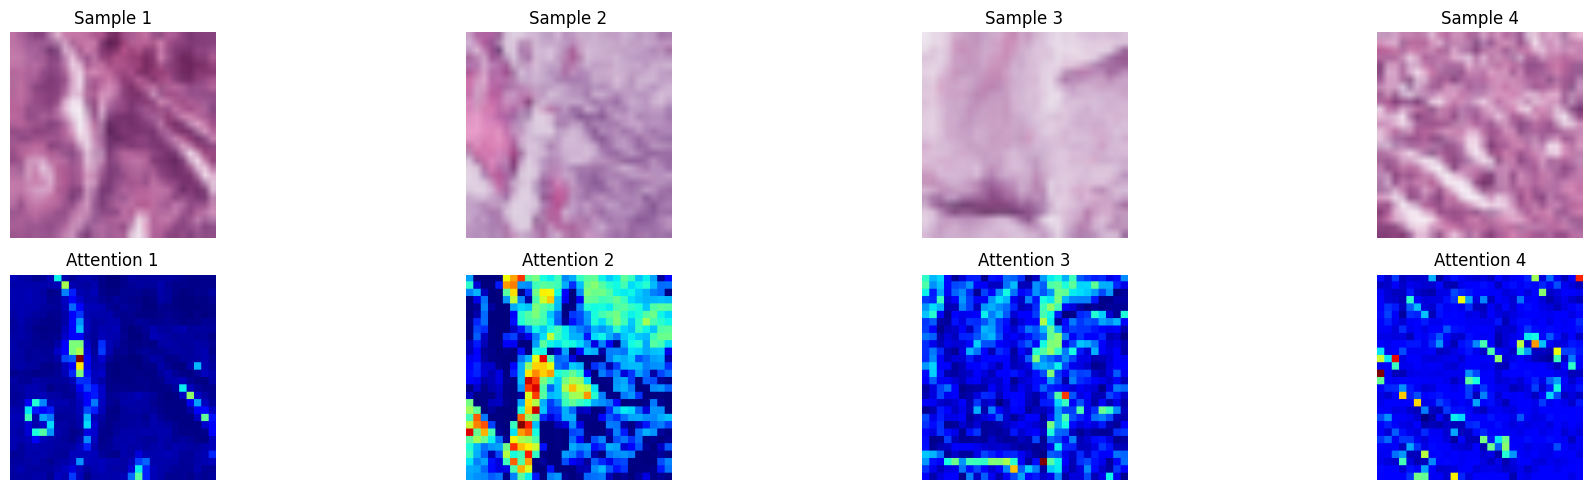

In [74]:
attention_maps = attention_tool.explain(samples)

fig, axes = plt.subplots(2, samples.size(0), figsize=(20, 5))

for i in range(samples.size(0)):
    image = samples[i].permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5) + 0.5

    attention_map = attention_maps[i].cpu().numpy()

    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(attention_map, cmap='jet')
    axes[1, i].set_title(f"Attention {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


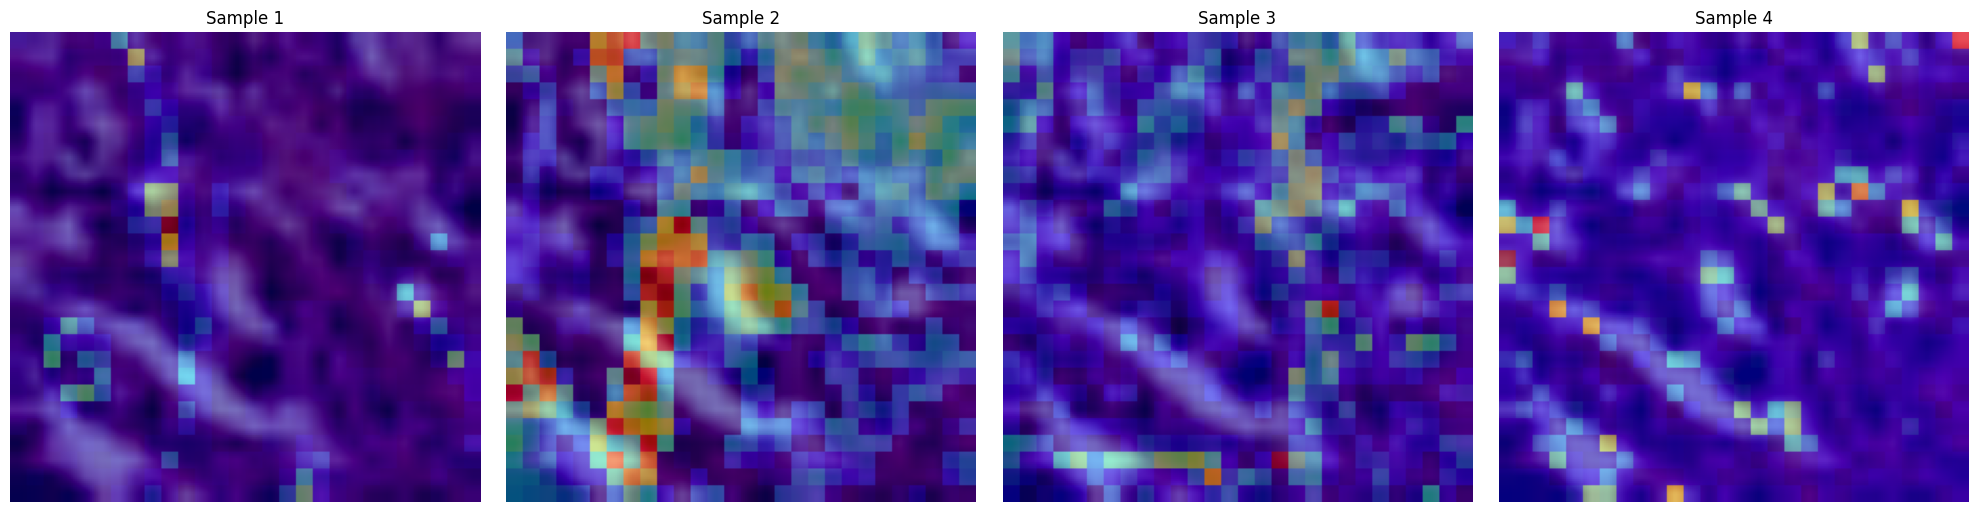

In [71]:
fig, axes = plt.subplots(1,  samples.size(0), figsize=(20, 5))
for i in range(samples.size(0)):
    image = samples[i].permute(1, 2, 0).cpu().numpy()
    attention_map = attention_maps[i].cpu().numpy()
    axes[i].imshow(original_image, cmap='gray')
    axes[i].imshow(attention_map, cmap='jet', alpha=0.5)
    axes[i].set_title(f"Sample {i + 1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

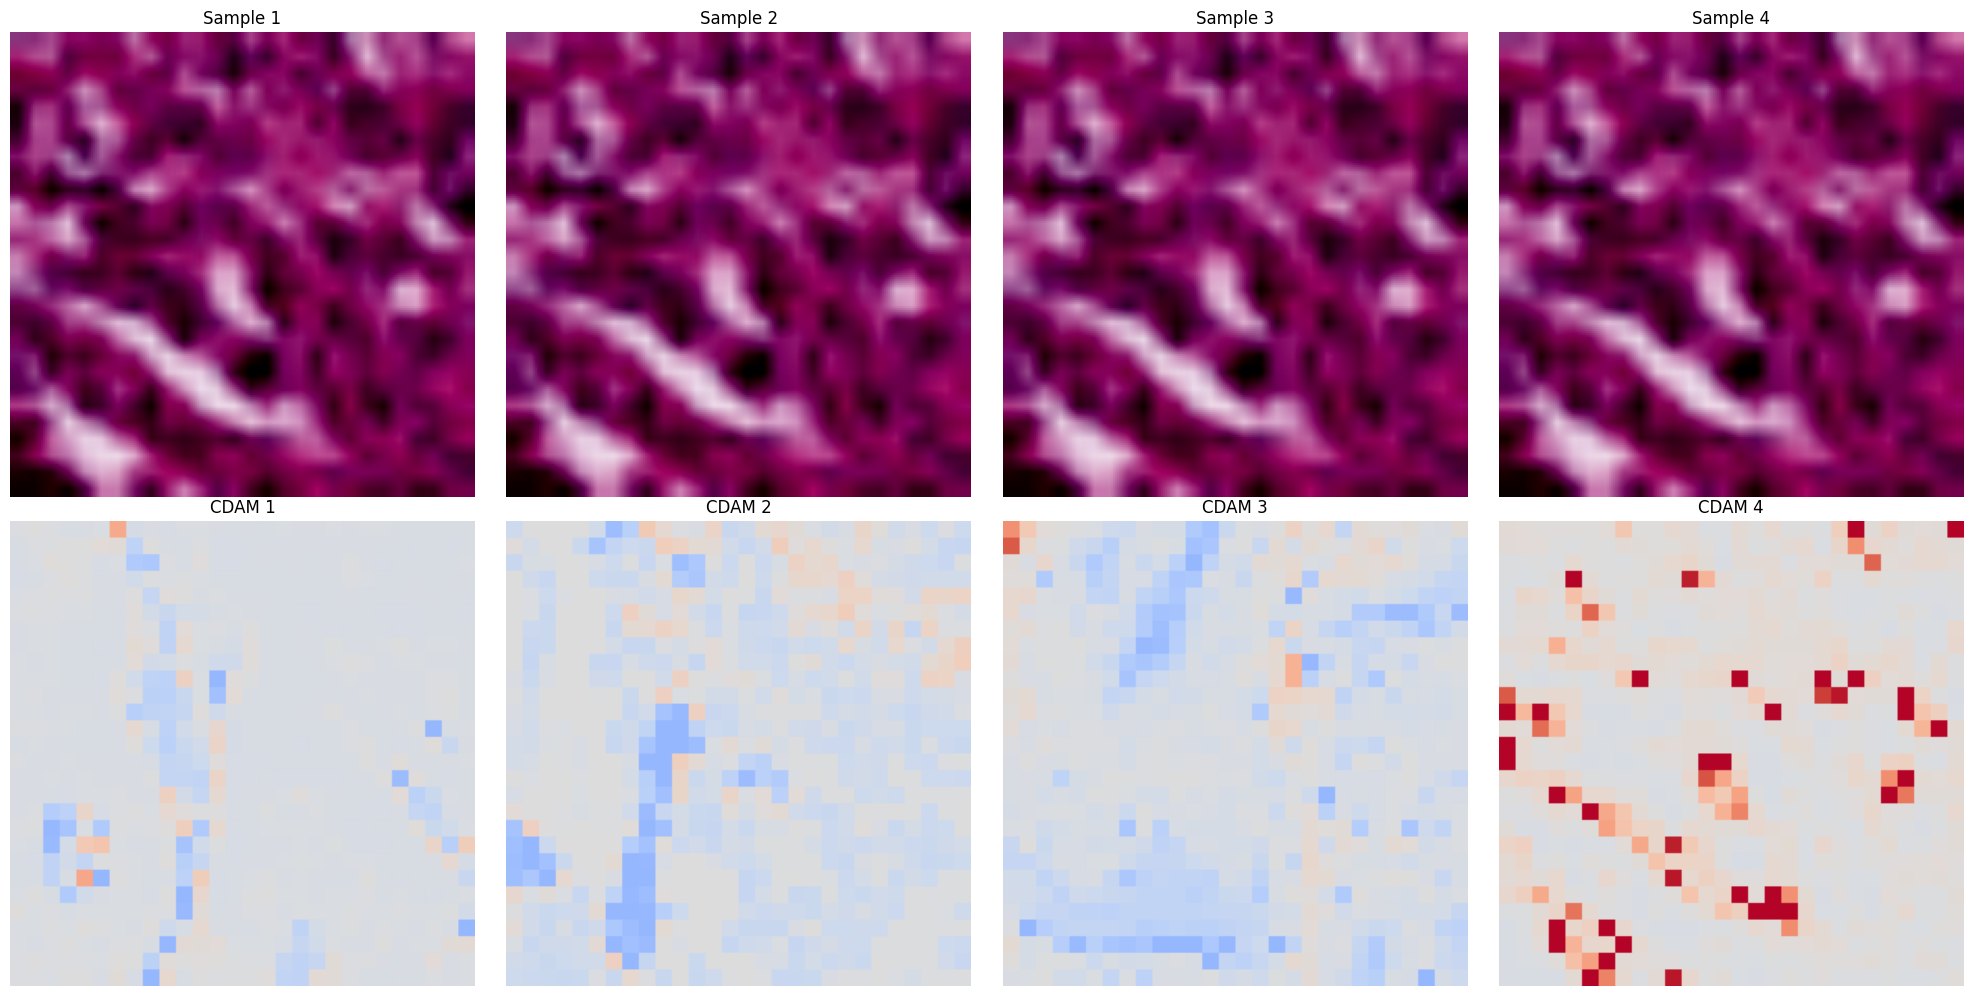

In [72]:
cdam_maps = cdam_tool.explain(samples, target_idx=predictions.tolist())

fig, axes = plt.subplots(2, samples.size(0), figsize=(20, 10))
for i in range(samples.size(0)):
    image = samples[i].permute(1, 2, 0).cpu().numpy()
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

    cdam_map = cdam_maps[i].squeeze().cpu().numpy()
    axes[1, i].imshow(cdam_map, cmap='coolwarm', vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())
    axes[1, i].set_title(f"CDAM {i + 1}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

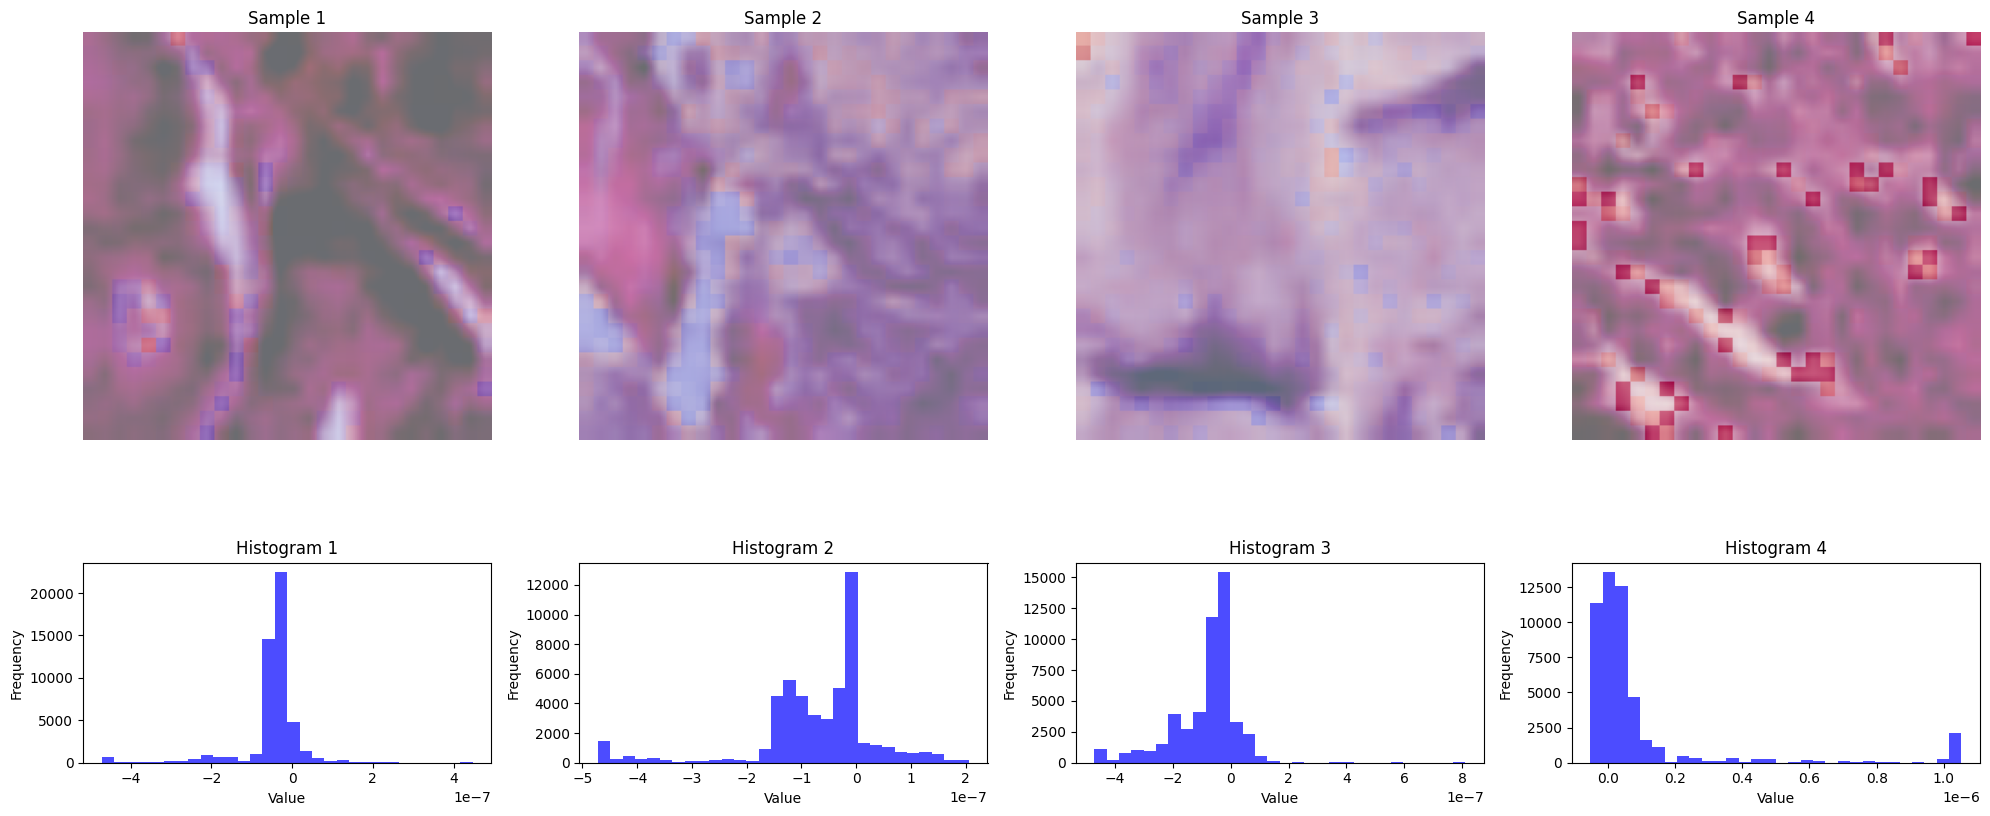

In [73]:
fig, axes = plt.subplots(2, samples.size(0), figsize=(20, 10), gridspec_kw={'height_ratios': [4, 1]})
for i in range(samples.size(0)):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].imshow(cdam_map, cmap='coolwarm', alpha=0.5, vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

    axes[1, i].hist(cdam_map.ravel(), bins=30, color='blue', alpha=0.7)
    axes[1, i].set_title(f"Histogram {i + 1}")
    axes[1, i].set_xlabel('Value')
    axes[1, i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()